## Executive summary: This binary classifier model is used to identify bank customers who may be appropriate candidates for an upcoming marketing campaign to cross-sell Certificate of Deposit (CD) products
- Note: this model is for educational purposes only and should be be relied up for making business or credit decisions
- Author: Will Merline

In [7]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [8]:
#1. import dataset:
df = pd.read_csv('Data/Banking_Data.csv')
df.head()

,age,job,marital,education,balance,housing,loan,y
0,58,management,married,tertiary,2143,yes,no,no
1,44,technician,single,secondary,29,yes,no,no
2,33,entrepreneur,married,secondary,2,yes,yes,no
3,47,blue-collar,married,unknown,1506,yes,no,no
4,33,unknown,single,unknown,1,no,no,no


In [9]:
df.describe(include='all')

,age,job,marital,education,balance,housing,loan,y
count,45211.00000,44900,45211,45211,45211.000000,45211,45211,45197
unique,NaN,12,3,4,NaN,2,2,2
top,NaN,blue-collar,married,secondary,NaN,yes,no,no
freq,NaN,9674,27214,23202,NaN,25130,37967,39909
mean,40.86417,NaN,NaN,NaN,1310.900290,NaN,NaN,NaN
std,10.75041,NaN,NaN,NaN,3806.997684,NaN,NaN,NaN
min,0.00000,NaN,NaN,NaN,-99999.000000,NaN,NaN,NaN
25%,33.00000,NaN,NaN,NaN,72.000000,NaN,NaN,NaN
50%,39.00000,NaN,NaN,NaN,448.000000,NaN,NaN,NaN
75%,48.00000,NaN,NaN,NaN,1426.500000,NaN,NaN,NaN


In [10]:
#2. identify nulls in the data and remove or impute:
df.isnull().sum()/len(df)

age          0.000000
job          0.006879
marital      0.000000
education    0.000000
balance      0.000000
housing      0.000000
loan         0.000000
y            0.000310
dtype: float64

2. Target variable - missing target variables usually cannot be imputed (unless we are very confident about the value from prior knowledge or other reasoning from the dataset) because they determine how the model learns. For this exercise, I am dropping the small percentage of missing target values

    Job - 'Job' variable also has a small percentage of missing values. Because this is a categorical variable, I could replace missing values with the most frequently appearing category. However, because we also have 'unknown' as a category, I am going to change missing job values to 'unknown'.


In [11]:
#2.2 drop missing values for y (target variable)
df2 = df.copy()
df2.dropna(subset=['y'], inplace=True)

In [12]:
#2.3 Imputation: change missing job values to 'unknown'
df2['job'] = df['job'].fillna('unknown')

In [13]:
#2.4 check the missing values were removed for y and job
df2.isnull().sum()/len(df2)

age          0.0
job          0.0
marital      0.0
education    0.0
balance      0.0
housing      0.0
loan         0.0
y            0.0
dtype: float64

3. To check for erroneous data, I took two approaches:
    A. For all columns besides age, I printed the values counts to check for misspellings, strange values, etc.
        - Education column has a small percentage (<5%) of values labeled 'unknown'. These values could potentially be imputed, but because I have no thesis about their true values based on the other education categories I am leaving them as 'unknown'

    B. For age, I checked for negative values, values equal to zero, values below 16. I selected 16 as an arbitrary cutoff for a reasonable age to have a bank account.
        - There are 81 values equal to zero. I assume these values are data errors, as someone zero years of age likely does not have a bank account, job, etc. I chose to impute these zeros using median age


In [14]:
#3. Identify any erroneous data:
    # print values counts for each variable to check for data errors (misspelling, strange values, etc.):
for col_name in df2.iloc[0: ,1:]:
    print('Column', col_name,' values:' ,df2[col_name].value_counts())

Column job  values: blue-collar      9671
management       9378
technician       7549
admin.           5132
services         4123
retired          2245
self-employed    1566
entrepreneur     1479
unemployed       1292
housemaid        1235
student           933
unknown           594
Name: job, dtype: int64
Column marital  values: married     27206
single      12785
divorced     5206
Name: marital, dtype: int64
Column education  values: secondary    23192
tertiary     13299
primary       6850
unknown       1856
Name: education, dtype: int64
Column balance  values: 0        3513
1         195
2         155
4         139
3         134
         ... 
4043        1
6812        1
10077       1
11754       1
16353       1
Name: balance, Length: 7168, dtype: int64
Column housing  values: yes    25120
no     20077
Name: housing, dtype: int64
Column loan  values: no     37955
yes     7242
Name: loan, dtype: int64
Column y  values: no     39909
yes     5288
Name: y, dtype: int64


In [15]:
#3.1 Detect data errors for column age by checking for zeros and negative numbers:
print('Age values which are negative:',(df2['age'] <0).sum())
print('Age values equal to zero:', (df2['age'] ==0).sum())
print('Age values greater than zero and less than 16:', ((df2['age'] <16) & (df2['age'] >0)).sum())

Age values which are negative: 0
Age values equal to zero: 81
Age values greater than zero and less than 16: 0


In [16]:
#3.2 Check median value of age column
df2['age'].median() 

39.0

In [17]:
#3.3 Imputation: replace zeros in age column with mean of age column 
df3 = df2.copy()
df3['age'] = df3['age'].replace(0, df3['age'].median())

In [18]:
#3.3 Check age values after imputation
print('Age values which are negative:',(df3['age'] <0).sum())
print('Age values equal to zero:', (df3['age'] ==0).sum())
print('Age values greater than zero and less than 16:', ((df3['age'] <16) & (df3['age'] >0)).sum())

Age values which are negative: 0
Age values equal to zero: 0
Age values greater than zero and less than 16: 0


In [19]:
#4. Target variable (y):
    # then split the data into train (80%) and test (20%) sets:
X = df3.copy()
y = X['y']
X = X.drop(columns = 'y')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)


In [20]:
#5. Exploratory data analysis of train data:
X.describe(include='all')

,age,job,marital,education,balance,housing,loan
count,45197.000000,45197,45197,45197,45197.000000,45197,45197
unique,NaN,12,3,4,NaN,2,2
top,NaN,blue-collar,married,secondary,NaN,yes,no
freq,NaN,9671,27206,23192,NaN,25120,37955
mean,40.934664,NaN,NaN,NaN,1311.152997,NaN,NaN
std,10.610927,NaN,NaN,NaN,3807.483417,NaN,NaN
min,18.000000,NaN,NaN,NaN,-99999.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,72.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,448.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,1427.000000,NaN,NaN


In [21]:
#5.1 Exploratory data analysis of train data:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45197 entries, 0 to 45210
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45197 non-null  int64 
 1   job        45197 non-null  object
 2   marital    45197 non-null  object
 3   education  45197 non-null  object
 4   balance    45197 non-null  int64 
 5   housing    45197 non-null  object
 6   loan       45197 non-null  object
dtypes: int64(2), object(5)
memory usage: 2.8+ MB


In [22]:
#5.2 Exploratory data analysis of train data: housing loans and personal loans:
counts = X[['housing','loan']].value_counts()
percs = X[['housing','loan']].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

pd.concat([counts, percs], axis=1, keys=['Count','%'])

,,Count,%
housing,loan,,
yes,no,20754,45.9%
no,no,17201,38.1%
yes,yes,4366,9.7%
no,yes,2876,6.4%


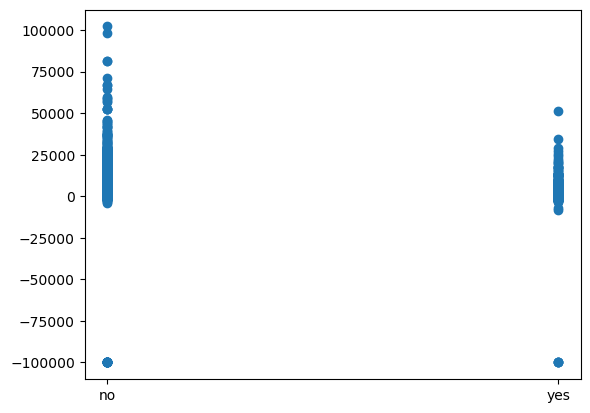

In [23]:
#5.3 Exploratory data analysis of train data:
plt.scatter(X['loan'], X['balance'])

'5. Exploratory analysis - 46% of the customers in this dataset have a housing loan but not a personal loan with this bank. This group of existing customers could be candidates for cross-selling opportunities by offering personal loans with better rates, lower fees, etc. Further analysis could be performed to identify which of these customers carry credit card balances and offer these customers low interest rate personal loans to payoff higher interest rate credit card debt.

In [24]:
#6 Dummy coding the categorical variables:
cat_vars = ['job', 'marital', 'education', 'housing', 'loan']
num_vars = ['age', 'balance']


In [25]:
#6.1 arrange unique categories in alphabetical order to determine and check which categories will:
  # value to be dropped in dummy coding:
for dummy_col in cat_vars:
  i = np.unique(np.array([X_train[dummy_col]]))
  print(dummy_col, "- base / zero category is:", i[0])

job - base / zero category is: admin.
marital - base / zero category is: divorced
education - base / zero category is: primary
housing - base / zero category is: no
loan - base / zero category is: no


In [26]:
#6.2 Dummy coding the categorical variables:
X_train_dummied = pd.get_dummies(X_train, columns=cat_vars, drop_first=True)
X_test_dummied = pd.get_dummies(X_test, columns=cat_vars, drop_first=True)

In [27]:
#6.3 Check train data after dummy coding the categorical variables:
X_train_dummied.head().transpose()

,38766,36700,10665,13723,8301
age,35,51,57,47,34
balance,13,480,145,184,1090
job_blue-collar,0,1,0,0,1
job_entrepreneur,0,0,0,0,0
job_housemaid,0,0,0,0,0
job_management,1,0,0,1,0
job_retired,0,0,0,0,0
job_self-employed,0,0,0,0,0
job_services,0,0,0,0,0
job_student,0,0,0,0,0


In [28]:
#6.3 Check test data after dummy coding the categorical variables:
X_test_dummied.head().transpose()

,36195,31628,10517,33990,4103
age,55,26,47,30,43
balance,2059,1804,7,1185,445
job_blue-collar,1,0,1,0,0
job_entrepreneur,0,0,0,0,0
job_housemaid,0,0,0,0,0
job_management,0,0,0,0,0
job_retired,0,0,0,0,0
job_self-employed,0,0,0,0,0
job_services,0,0,0,0,0
job_student,0,1,0,0,0


In [29]:
#7. Encode the target column (y) as 0 (no) and 1 (yes):
y_train_numeric = y_train.replace({'no': 0, 'yes': 1})
y_test_numeric = y_test.replace({'no': 0, 'yes': 1})

In [30]:
#7.1 Check target:
print(y_train_numeric.head())
print(y_test_numeric.head())

38766    0
36700    0
10665    0
13723    0
8301     0
Name: y, dtype: int64
36195    0
31628    0
10517    0
33990    0
4103     0
Name: y, dtype: int64


In [31]:
#8. Calculate the prevalence (class balance) of the target:
y_train_counts = y_train_numeric.value_counts()
y_train_percs = y_train_numeric.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

y_test_counts = y_test_numeric.value_counts()
y_test_percs = y_test_numeric.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

print(pd.concat([y_train_counts, y_train_percs], axis=1, keys=['y_train - Count','y_train - %']))
print(pd.concat([y_test_counts, y_test_percs], axis=1, keys=['y_test - Count','y_test - %']))

   y_train - Count y_train - %
0            31916       88.3%
1             4241       11.7%
   y_test - Count y_test - %
0            7993      88.4%
1            1047      11.6%


8. Train and test datasets have a very similar class balance of the target variable

In [32]:
#9. Logistic regression model on the training set:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=4)

In [33]:
#9.1 Get coefficients:
log_reg.fit(X_train_dummied, y_train_numeric)


LogisticRegression(random_state=4)

In [34]:
#10. Probability predictions:
preds = log_reg.predict_proba(X_test_dummied)
print(preds)

[[0.96231199 0.03768801]
 [0.70579087 0.29420913]
 [0.86170415 0.13829585]
 ...
 [0.87326936 0.12673064]
 [0.83321175 0.16678825]
 [0.79242735 0.20757265]]


In [35]:
#11. Calculate the area under the ROC curve of your predictions on the test set:
from sklearn.metrics import roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay, roc_curve

roc_auc_score(y_test_numeric, preds[:,1])

0.6444807066737358

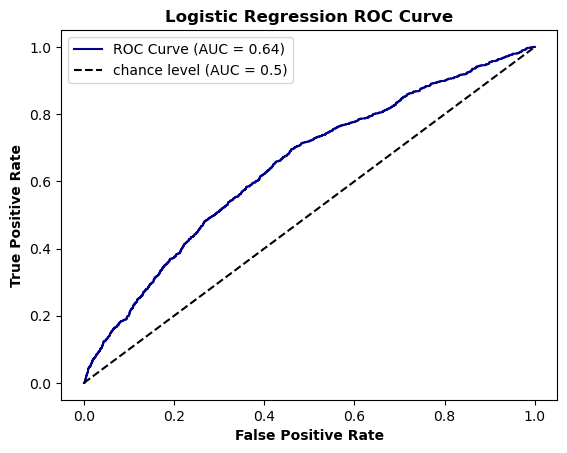

<Figure size 10000x5000 with 0 Axes>

In [36]:
#11.1 Plot ROC curve:
from scipy.ndimage import label
from matplotlib.pyplot import Figure
RocCurveDisplay.from_predictions(
    y_test_numeric, 
    preds[:,1],
    name='ROC Curve',
    color="darkblue",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("auto")
plt.xlabel("False Positive Rate", fontweight = "bold")
plt.ylabel("True Positive Rate", fontweight = "bold")
plt.title("Logistic Regression ROC Curve", fontweight = "bold")
plt.legend()
plt.figure(figsize=(100,50))
plt.show()

In [37]:
#12. Decision threshold:
t = 0.10

12. I have selected a decision threshold of .10. This low threshold can be justified for two reasons:
    (1) The train and test data for the target (y) are both heavily skewed towards 0 (no). See step 8 above for breakdown
    (2) The "costs" of a false positive include employee time to make phone calls to potential customers and the potential risk of annoying customers with sales calls. The "costs" of false negative include lost revenue opportunities. Assuming the lost revenue cost more than the false positives, it is better to have a lower threshold for this scenario

[[3942 4051]
 [ 289  758]]
False positive rate = 0.507
True positive rate = 0.724
Difference = 0.217


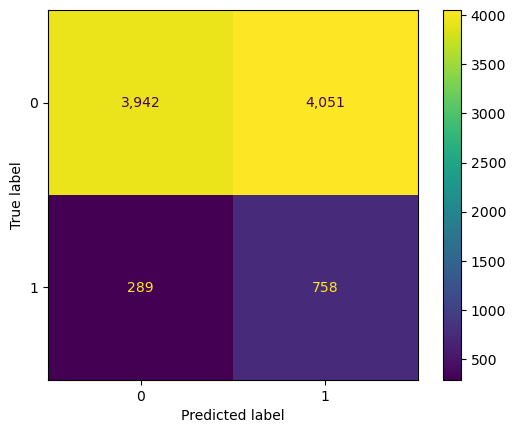

In [39]:
#13. Confusion matrix:
cm = confusion_matrix(y_test_numeric, pd.Series([1 if x > t else 0 for x in preds[:,1]]))

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

TN = cm[0][0]
FN = cm[1][0]
FP = cm[0][1]
TP = cm[1][1]

FPR = FP/(FP+TN)
TPR = TP/(TP+FN)


print(cm)
cm_display.plot(values_format=',d', xticks_rotation='horizontal')

print('False positive rate =', FPR.round(3))
print('True positive rate =', TPR.round(3))
print('Difference =', (TPR - FPR).round(3))

### Data quality - Overall this dataset has relatively few issues to deal with. Less than 10% of the data needed to be imputed, corrected, transformed, or otherwise changed. For this reason, the data is appropriate for modeling the target variable (y). The dataset could be improved though. For example:
- Both Job and Education columns have a category labeled "unknown". In an ideal data collection process, we would know the true values of these rows
- Balance is a bit ambiguous. Does this refer to bank account balance? Credit card balance, etc.?
- A few additional variables could also be useful, including: length of customer relationship with the bank, income, etc.

### Model quality - With an area under the curve of 0.64, the model is slightly better than random chance. Choosing a low decision threshold can potentially make the model more generalizable and improve recall. Additional feature engineering could lead to a better model (potentially for the Balance variable)

### Recommendation:
- If the bank has access to a robust call center or other customer marketing operation with reasonable labor costs, this model could be leveraged to identify customers who are most likely to subscribe the bank term deposit product. The bank should run its customer database through this model to identify top customer candidates
- If the bank has access to relatively cheap call center labor, the model's decision threshold could be set low in order to target a wider breadth of customers
- If the bank's marketing outreach costs are high, the decision threshold could be raised to target less customers
- Note: certain demographic variables such as edcuation, age, maritial status, etc. should be used with caution in most predictive models.